# Détection d'instants
Quand on dispose d'un signal temporel on cherche souvent à en analyser une partie. Pour cela il faut détecter un instant particulier ou délimiter des bornes (deux instants). A chaque fois qu'un instant doit être choisi, les analystes développent un code spécifique qui a toutes les chances d'être difficile à maintenir car des éléments inattendus peuvent survenir avec l'arrivée de nouveaux signaux.

Hors dans la majorité des cas l'instant qui intéresse un expert est clairement visible sur l'un des signaux temporels univarié, éventuellement la conjonction de deux signaux, mais rarement plus. Par ailleurs, sur le signal en question cet instant est facilement identifiable : il est proche d'une bosse ou d'un creu et en fonction de l'échelle d'observation on doit facilement le détecter puisque c'est un élément essentiellement visuel.

Ce module utilise un Opset en entrée, construit une interface permettant l'identification graphique par un expert de l'instant choisi sur quelques signaux.
Ensuite un algorithme fabrique des indicateurs basés sur la détection de creux et de bosses et extrait des points au hasard sur les courbes visualisées par l'expert. Chacun de ces points est un vecteur de grande dimension dont les coordonnées correspondent à des indicateurs de position (numéro et position des creux et bosses) à différentes échelles.
L'algorithme essaye de détecter si les points tirés sont à gauche (-1) ou à droite (+1) de l'instant sélectionné.

Finalement un indicateur d'estimation de présence de l'instant est construit et une détection est faite avec plus ou moins de confiance.

L'expert peut tester son détecteur et éventuellement le corriger en ajoutant des identifications manuelles et en relançant l'apprentissage. 

In [1]:
%matplotlib widget


In [2]:

import plotly.express as px
import plotly.graph_objects as go


In [3]:
import sys
import os

# Chemin absolu vers le dossier contenant "tabata/"
# Remplace-le si besoin
chemin_projet = os.path.expanduser("~/Téléchargements/projet_lacaille")
sys.path.append(chemin_projet)





In [4]:
import numpy as np
from scipy import signal
import pandas as pd
import tabata as tbt
from tabata import Opset, Selector

Pour des raisons de debuggage, je recharge le module.

### 🔍 Centralisation de l'accès aux données
Pour centraliser l'accès aux données, j'intègre une fonction `load_data(file_path)`.

In [5]:
def load_data(file_path):
    """Charge les données via le module tabata, en choisissant automatiquement Selector ou Opset selon le contexte."""
    from tabata import Selector, Opset
    if "CT" in file_path:
        data_obj = Opset(file_path)
    else:
        data_obj = Selector(file_path)
    return data_obj

# Exemple d'utilisation :
# S = load_data('data/out/AFL1EB_C.h5')


In [6]:
S=load_data('data/out/AFL1EB_C.h5')

### 📈 Amélioration des affichages
On crée une fonction `improve_plot` pour uniformiser les graphiques.

In [7]:
def improve_plot(fig, title="", x_title="", y_title=""):
    """Améliore l'apparence du graphique plotly fourni."""
    fig.update_layout(title=title, xaxis_title=x_title, yaxis_title=y_title,
                      legend=dict(orientation='h', y=-0.2), template='plotly_white',
                      autosize=True, hovermode='closest')
    fig.update_traces(marker=dict(size=4))
    fig.show()


### 🔧 Gestion des tubes et détecteurs d'instants
Réorganiser les appels pour clarifier les tubes, instants et affichages.

### 🛠️ Générateur de code Python à partir des sélections
La fonction `generate_code()` crée un script Python des instants détectés.

In [8]:
%reload_ext autoreload
%autoreload 2

## Création du sélecteur d'instants.
On utilise les données retraitées depuis le notebook _opset_doc_. Le Selector est un Opset disposant de fonctions de sélection dans son interface.

In [9]:
import os
print("📌 Répertoire de travail actuel :", os.getcwd())


📌 Répertoire de travail actuel : /home/ing/Téléchargements/projet_lacaille/tabata/notebooks


In [10]:
file_path = "data/in/AFL1EB.h5"


In [11]:
import h5py

file_path = "data/in/AFL1EB.h5"

with h5py.File(file_path, "r") as f:
    print(f"📁 Structure du fichier : {file_path}\n")

    def print_structure(name, obj):
        print("📂", name)

    f.visititems(print_structure)


📁 Structure du fichier : data/in/AFL1EB.h5

📂 record_00
📂 record_00/axis0
📂 record_00/axis1
📂 record_00/block0_items
📂 record_00/block0_values
📂 record_01
📂 record_01/axis0
📂 record_01/axis1
📂 record_01/block0_items
📂 record_01/block0_values
📂 record_02
📂 record_02/axis0
📂 record_02/axis1
📂 record_02/block0_items
📂 record_02/block0_values
📂 record_03
📂 record_03/axis0
📂 record_03/axis1
📂 record_03/block0_items
📂 record_03/block0_values
📂 record_04
📂 record_04/axis0
📂 record_04/axis1
📂 record_04/block0_items
📂 record_04/block0_values
📂 record_05
📂 record_05/axis0
📂 record_05/axis1
📂 record_05/block0_items
📂 record_05/block0_values
📂 record_06
📂 record_06/axis0
📂 record_06/axis1
📂 record_06/block0_items
📂 record_06/block0_values
📂 record_07
📂 record_07/axis0
📂 record_07/axis1
📂 record_07/block0_items
📂 record_07/block0_values
📂 record_08
📂 record_08/axis0
📂 record_08/axis1
📂 record_08/block0_items
📂 record_08/block0_values
📂 record_09
📂 record_09/axis0
📂 record_09/axis1
📂 record_09/block

In [12]:
S = load_data('data/in/AFL1EB.h5')
print(S)          # affichage de base
print(S.df.head()) # voir les premières données
print(S.variables) # vérifier quelles variables sont chargées


OPSET 'data/in/AFL1EB.h5' de 52 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 0 instant(s) sélectionnés parmis 0 courbes observées et 0 variables.
                       ALT[m]     Tisa[K]  TAS[m/s]   Vz[m/s]     Masse[kg]  \
record_00                                                                     
2012-07-10 11:08:00 -1.267968  829.894823       0.0  0.017541  15217.558677   
2012-07-10 11:08:01 -1.267968  829.894823       0.0  0.016004  15217.558677   
2012-07-10 11:08:02 -1.267968  829.894823       0.0  0.014466  15217.558677   
2012-07-10 11:08:03 -1.267968  829.894823       0.0  0.012929  15217.558677   
2012-07-10 11:08:04 -1.267968  829.894823       0.0  0.011392  15217.558677   

                     F[N]  
record_00                  
2012-07-10 11:08:00   0.0  
2012-07-10 11:08:01   0.0  
2012-07-10 11:08:02   0.0  
2012-07-10 11:08:03   0.0  
2012-07-10 11:08:04   0.0  
s

In [13]:
print(S.df.columns)

Index(['ALT[m]', 'Tisa[K]', 'TAS[m/s]', 'Vz[m/s]', 'Masse[kg]', 'F[N]'], dtype='object')


In [14]:
S.variables = set(S.df.columns)
print(S.variables)


{'TAS[m/s]', 'ALT[m]', 'F[N]', 'Masse[kg]', 'Vz[m/s]', 'Tisa[K]'}


On affiche les observations (comme pour Opset), mais la différence est dans l'utilisation du clic de souris. En cliquant sur la courbe on peut sélectionner un instant.

In [15]:

fig = S.plot(name='ALT[m]')

from IPython.display import display
display(fig)



In [18]:
for i, child in enumerate(fig.children):
    print(f"Onglet {i} : {type(child)}")


Onglet 0 : <class 'ipywidgets.widgets.widget_box.VBox'>
Onglet 1 : <class 'ipywidgets.widgets.widget_box.VBox'>
Onglet 2 : <class 'ipywidgets.widgets.widget_box.VBox'>


In [19]:
for i, child in enumerate(fig.children):
    print(f"Onglet {i} (VBox) contient :")
    for j, subchild in enumerate(child.children):
        print(f"  Élément {j} : {type(subchild)}")


Onglet 0 (VBox) contient :
  Élément 0 : <class 'ipywidgets.widgets.widget_box.HBox'>
  Élément 1 : <class 'ipywidgets.widgets.widget_box.HBox'>
  Élément 2 : <class 'ipywidgets.widgets.widget_box.HBox'>
Onglet 1 (VBox) contient :
  Élément 0 : <class 'ipywidgets.widgets.widget_box.VBox'>
  Élément 1 : <class 'ipywidgets.widgets.widget_box.VBox'>
Onglet 2 (VBox) contient :
  Élément 0 : <class 'ipywidgets.widgets.widget_int.IntProgress'>
  Élément 1 : <class 'ipywidgets.widgets.widget_box.HBox'>


In [41]:
for i, child in enumerate(fig.children):
    print(f"Onglet {i} ({type(child).__name__}) contient :")
    for j, subchild in enumerate(child.children):
        print(f"  Élément {j} ({type(subchild).__name__}) contient :")
        if hasattr(subchild, 'children'):
            for k, subsubchild in enumerate(subchild.children):
                print(f"    Sous-élément {k} : {type(subsubchild)}")
        else:
            print(f"    Pas de sous-éléments")


Onglet 0 (VBox) contient :
  Élément 0 (HBox) contient :
    Sous-élément 0 : <class 'ipywidgets.widgets.widget_selection.Dropdown'>
    Sous-élément 1 : <class 'ipywidgets.widgets.widget_button.Button'>
    Sous-élément 2 : <class 'ipywidgets.widgets.widget_button.Button'>
  Élément 1 (HBox) contient :
    Sous-élément 0 : <class 'plotly.graph_objs._figurewidget.FigureWidget'>
    Sous-élément 1 : <class 'ipywidgets.widgets.widget_int.IntSlider'>
  Élément 2 (HBox) contient :
    Sous-élément 0 : <class 'ipywidgets.widgets.widget_int.IntSlider'>
Onglet 1 (VBox) contient :
  Élément 0 (VBox) contient :
    Sous-élément 0 : <class 'ipywidgets.widgets.widget_string.Label'>
    Sous-élément 1 : <class 'ipywidgets.widgets.widget_box.HBox'>
    Sous-élément 2 : <class 'ipywidgets.widgets.widget_box.HBox'>
  Élément 1 (VBox) contient :
    Sous-élément 0 : <class 'ipywidgets.widgets.widget_string.Label'>
    Sous-élément 1 : <class 'ipywidgets.widgets.widget_box.HBox'>
    Sous-élément 2 : <

In [42]:
import plotly.io as pio

fig_widget = fig.children[0].children[1].children[0]  # Accès à la FigureWidget

# Sauvegarde en PNG avec kaleido
pio.write_image(fig_widget, "fig_alt_onglet0.png")


![Figure Onglet 0](fig_alt_onglet0_0.png)


Un onglet "Param" offre une interface de paramétrage de l'apprentissage. Les caractéristiques de ces paramètres sont décrits plus bas.

L'onglet "Learn" a un bouton qui permet de lancer ou relancer un apprentissage.
Il est rouge parce que l'on a pas encore montré à l'algorithme quels sont les instants à identifier. Dès que l'on aura cliqué sur un point de la courbe une barre verticale mettra en évidence cet instant et le bouton passera ua bleu pour montrer que l'on peut déjà lancer un apprentissage. La liste à gauche du bouton correspond aux variables que peut sélectionner l'expert. Par défaut encore aucune variable n'est sélectionnée, mais dès qu'une courbe sera identifiée par une sélection d'instant, une variable sera choisie. L'expert peut modifier à tout instant cette sélection avant de lancer son apprentissage. Attention cependant, si aucune variable n'est sélectionnée l'algorithme ne peut utiliser que la position et la position relative des points sur les courbes.

Les points selectionnés sont stockés dans la variable `selected` et les signaux observés sont dans `viewed` et les variables visualisées dans `variables`. On a cette seconde variable car un expert qui voit un signal mais ne sélectionne pas d'instant donne une information qu'il est aussi possible d'exploiter.

Certains environnements comme "Google Collab" ne gèrent pas les `FigureWidgets` de Plotly ce qui empèche de cliquer sur un point de la courbe. C'est pourquoi une version légèrement dégradée est proposée avec la méthode `.plotc()`.

In [20]:
from IPython.display import display
try:
    fig2 = S.plotc(name='ALT[m]')
    display(fig2)
    print("Affichage avec plotc() réussi.")
except Exception as e:
    print("Erreur avec plotc() :", e)

Affichage avec plotc() réussi.


In [22]:
# Charger le signal
S = Selector("data/in/AFL1EB.h5")

# Ajouter les variables disponibles
S.variables = set(S.df.columns)

# Afficher le signal ALT[m] avec interactivité
try:
    S.plot(name="ALT[m]")
except Exception:
    S.plotc(name="ALT[m]")


Comme on ne peut plus cliquer sur la courbe, une barre horizontalle a été rajoutée, elle permet de sélectionner un point. Par contre pour annuler une sélection précédente, il faut penser à ramener la valeur de ce point à 0.

In [23]:
print('Instants selectionnés :\n', S.selected)
print('Signaux observés :\n', S.viewed)

Instants selectionnés :
 {}
Signaux observés :
 {0}


Pour des raisons de test nous supposerons que les instants et observations ont été sauvegardées.

In [24]:
S.selected = \
{0: 1960, 1: 1821, 3: 1732, 4: 1600, 5: 1391, 6: 1736, 
 7: 1615, 16: 2362, 18: 2622}

S.viewed = {0, 1, 3, 4, 5, 6, 7, 16, 18}

S.variables = {'ALT[m]'}

Pour les instants, la sauvegarde est un dictionnaire indexé par le numéro d'enregistrement (signal) avec pour valeur la position de l'instant choisi.

## Création des indicateurs.
Les indicateurs sont des compteurs de bosses et de creux. Une bosse ou un creu est détecté par le passage par zéro de la dérivée du signal. On utilise des échelles différentes pour lisser le signal et on regardera en plus des bosses et des creux les points d'inflexion qui sont les bosses et creux de la dérivée.

L'algorithme de lissage employé est un filtre de Savitsky-Golay : un filtre polynômial que l'on utilise avec des polynômes de degré 2. On fixe une largeur de filtre et sur chaque fenêtre on essaye d'estimer la courbe par une parabole, le résultat du filtre est la valeur au centre de la fenêtre. L'utilisation d'un polynôme de degré deux évite la surparamétrisation et autorise le calcul des dérivées d'ordre 1 et 2.

In [25]:
len(S)

52

In [26]:
S.variables = list(S.variables)  # conversion set → list
dsi = S.make_indicators()


La méthode `make indicator()` renvoie un nouveau Selector qui a ses propriétés `selected` et `viewed` vides, mais pas sa propriété `computed`. Cette dernière affiche les points sélectionnés précédemment par des traits pointillés en bleu. Ils ne sont pas modifiable contrairement aux sélections violettes.

In [27]:
dsi.plot()

En parcourant cet Opset, vous remarquerez que seules les opérations sélectionnées sont enregistrées. (On utilise ici un selector plutot qu'un Opset pour pouvoir visualiser les positions. Bien entendu un apprentissage n'a pas de sens sur ces données.)

D'autre part, en regardant la liste des variables on voit des noms un peu originaux :

* LEN correspond à la position absolue dans le signal ;
* REV est la position absolue inverse ;
* PERCENT est la position relative par rapport à la longuer du signal.

Les unités _pts_ et _%_ représentent le numéro de point et le pourcentage.

Les autres variables sont toutes de noms correspondants à la variable originale sélectionnée et l'unité ce code ainsi : _w#o#u#_ ou _w#o#d#_.

* _w_ correspond à la demi-largeur du filtre ;
* _o_ est l'ordre de dérivation (1 ou 2) ;
* _u_ et _d_ représentent un passage par zéro en montant (up) ou en descendant (down).

Ces valeurs sont issues du paramétrage par défaut de la méthode :

     def make_indicators(self, filename=None):
                        
Le nom du fichier par défaut sera le même que celui du Selector (même répertoire) avec le préfixe '_I'.

Cette fonction utilise des paramètres stockés dans un dictionnaire `features_params`.

In [28]:
S.feature_params

{'range_width': range(25, 251, 25),
 'range_sigma': range(5, 26, 10),
 'max_order': 2}

* `range_width` est un itérateur donnant les demi-largeurs qui correspond par défaut aux dix premiers centièmes de la longueur du plus petit signal (10 étant la plus petite valeur acceptable). Pour un signal de 1000 points on obtient `range(10,101,10)`.
* `range_sigma` est un itérateur des seuil permettant de détecter les passages par zéro, ce sont des multiples de l'écart-type local du signal lissé. Si le seuil est positif or regarde les passage par zéro en montant et s'il est négatif, les passages par zéro en descendant. Par défaut on prend `range(5,26,10)` et son opposé soit -25 -15 -5 5 15 25.
* `max_order` est l'ordre maximal de dérivation. Le degré du polynome estimé est égal à 2 par défaut sauf si on recherche des indicateurs d'ordre plus élevé, auquel cas le degré du polynome sera aussi augmenté.

## Apprentissage
L'apprentissage peut être lancé directement depuis l'affichage.

In [29]:
S.plot()

Remarquez que le boutton est passé au bleu parce qu'il existe désormais des signaux qui ont été labellisés. On peut appuyer sur ce bouton ou appeler la méthode `fit()`.

In [30]:
S.fit()

First keeping 21 indicators over 244
Then  keeping 5 indicators over 244


OPSET 'data/in/AFL1EB.h5' de 52 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 9 instant(s) sélectionnés parmis 9 courbes observées et 1 variables.

L'apprentissage utilise des arbres de décision. Dans un premier temps on recherche par une génération aléatoire d'un nombre d'arbres donnés (10 par défaut) quelles sont les indicateurs (features) les plus importantes. On extrait ces indicateurs puis on recommence des apprentissages d'arbre de décision en ne concervat à la fin que les indicateurs utiles. Ceux-ci sont mémorisés dans la variable `idcodes`.

In [31]:
S.idcodes

[('LEN', 0, 0, 0, 0.0),
 ('PERCENT', 0, 0, 0, 0.0),
 ('ALT[m]', -175, 0, -5, 0.1590257435968585),
 ('ALT[m]', 200, 1, 5, 0.004284129241648939),
 ('ALT[m]', -225, 0, 25, 0.21041374834611626)]

Chaque élément de cette liste est un 5-uplet :
* Le nom de la courbe traitée.
* La demi-largeur du filtre.
* L'ordre de dérivation moins 1 (0 est une dérivée, 1 est un laplacien).
* Le nombre d'écart-types pour le seuil de détection (positif par le haut et négatif par le bas).
* La valeur de l'écart-type conservée pour cette analyse.

L'interprétation des règles peut être obtenue par l'appel à la méthode `describe()`.

In [32]:
S.describe()

            Name  Filter  Order  Sigma       Std
Feature                                         
0            LEN       0      0      0  0.000000
1        PERCENT       0      0      0  0.000000
2         ALT[m]    -175      0     -5  0.159026
3         ALT[m]     200      1      5  0.004284
4         ALT[m]    -225      0     25  0.210414
|--- feature_0 <= 1731.50
|   |--- feature_3 <= 4.25
|   |   |--- feature_1 <= 0.63
|   |   |   |--- class: -1
|   |   |--- feature_1 >  0.63
|   |   |   |--- class: 1
|   |--- feature_3 >  4.25
|   |   |--- class: 1
|--- feature_0 >  1731.50
|   |--- feature_2 <= 4.53
|   |   |--- feature_4 <= 0.98
|   |   |   |--- feature_2 <= 4.53
|   |   |   |   |--- feature_0 <= 1735.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  1735.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  4.53
|   |   |   |   |--- class: 1
|   |   |--- feature_4 >  0.98
|   |   |   |--- class: -1
|   |--- feature_2 >  4.53
|   |   |--- class:

In [33]:
S.plot()

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Un nouvel affichage montre qu'une détection a été faite. Un trait pointillé bleu se superpose au choix de l'utilisateur (rouge). La courbe en bas représente l'estimation de présence.

Le bouton est passé au vert pour montrer que tout s'est bien passé. On peut continuer à sélectionner des instants et relancer l'apprentissage.

Si on avance dans l'Opset on peut observer des détections sur des observations que l'on avait pas regardé.

In [34]:
S.plot(pos=8)

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



La barre de défilement "Filter" permet de modifier la taille du filtre de prédiction. Pour cet exemple simple vous verrez en la modifiant que cela ne change pas grand chose. Cependant dans des cas plus complexes, il peut y avoir un niveau de doute plus important et cela peut être intéressant de visualiser celui-ci. Le paramètre de lissage est stocké dans le dictionnaire `predict_params`.

In [35]:
S.predict_params

{'filter_width': 100}

Les paramètres d'apprentissage sont stockés dans le dictionnaire `learn_params`.

In [36]:
S.learn_params

{'retry_number': 10,
 'retry_percentile': 80,
 'samples_percent': 0.01,
 'min_samples_split': 0.05}

* `retry_number` est le nombre d'arbres aléatoires fabriqués pour la recherche des indicateurs pertinents.
* `retry_percentile` est un quantile sur la fréquence minimale pour laquelle l'indicateur doit être obnservé pour être retenu.
* `samples_percent` est le pourcentage de points extrait des courbes pour l'apprentissage de chaque arbre.
* `min_sample_split` est le taux minimal d'observations en dessous duquel les arbres ne se développeront plus.

Les paramètres pour les indicateurs et l'apprentissage peuvent être modifiés graphiquement depuis une petite interface spécialisée.

In [37]:
S.param()

## Prédictions

La fonction `belief(df)` renvoit l'estimateur de position pour le DataFrame courant ou un DataFrame externe. Si le DataFrame est issu de la position courante alors la détection sera calculée et le dictionnaire `computed` mis à jour.

On construit une liste de données différente de la première pour simuler un jeu de test sachant que l'on a appris les instants que sur les premières observations.

In [38]:



teststore = "data/out/AFL1EB_CT.h5"
ST = Opset(teststore)
ST.clean()  

for df in S[-10:]:
    ST.put(df)


In [39]:
ST.records

['/record_42',
 '/record_43',
 '/record_44',
 '/record_45',
 '/record_46',
 '/record_47',
 '/record_48',
 '/record_49',
 '/record_50',
 '/record_51']

Affichons le score du troisième individu. 

In [40]:

#from plotly.offline import init_notebook_mode, iplot
#import plotly.io as pio

#pio.renderers.default = "vscode"
#df = ST[1]
#p = S.belief(df)
#mx = np.argmax(p)
#print("Maximum for point", mx, "at", df.index[mx])
#px.line(x=df.index,y=p*100,
       # height=300,
        #title="Prédiction de l'instant",
        #labels={'x':'date', 'y':'%'}
       #)

  



def afficher_prediction(S, ST, idx=0):
    df = ST[idx]
    p = S.belief(df)
    mx = np.argmax(p)
    instant_max = df.index[mx]

    print(f"\n--- Résultat pour l'individu {idx} ---")
    print(f"🕒 Instant prédit : {instant_max}")
    print(f"📍 Index du maximum : {mx}")

    fig = px.line(
        x=df.index,
        y=p * 100,
        height=300,
        title=f"🔍 Prédiction de l'instant pour l'individu {idx}",
        labels={'x': 'Date', 'y': 'Probabilité (%)'}
    )

    
    fig.add_shape(
        type="line",
        x0=instant_max,
        x1=instant_max,
        y0=0,
        y1=100,
        line=dict(color="red", dash="dash"),
    )

    
    fig.add_annotation(
        x=instant_max,
        y=100,
        text="Instant prédit",
        showarrow=True,
        arrowhead=1,
        ax=0,
        ay=-40,
        font=dict(color="red")
    )

    fig.show()




--- Résultat pour l'individu 1 ---
🕒 Instant prédit : 2013-02-14 11:19:10
📍 Index du maximum : 2230


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



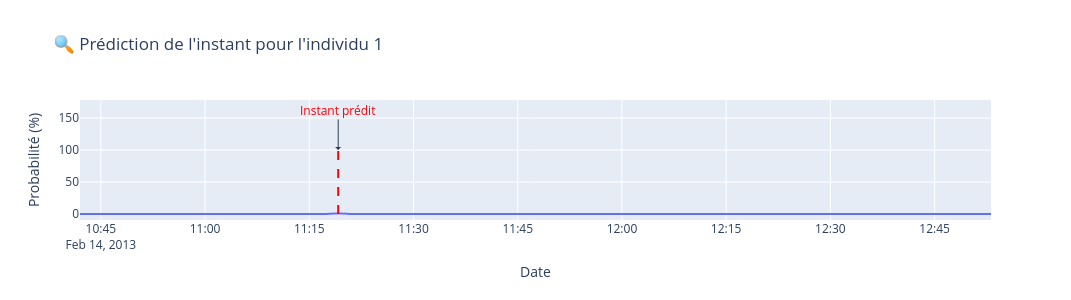

In [36]:
afficher_prediction(S, ST, idx=1)


La prédiction globale pour tout le fichier s'obtient facilement à l'aide de la méthode `predict()`. Le retour correspond à la variable `computed` ce qui permet de visualiser toutes les prédictions sans avoir à les recalculer.

In [37]:
r = S.predict()
print("Instant signal", S.records[8], "#", 8, "on", r[8], "at", S[8].index[r[8]])

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

Instant signal /record_08 # 8 on 508 at 2013-01-05 09:51:29


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

Pour prédire sur tout un fichier il suffit de le passer en argument. On peut aussi passer un Opset ce qui rend les manipulations plus pratiques.

In [38]:
r = S.predict(ST)
print("Instant signal", ST.records[8], "#", 8, "on", r[8], "at", ST[8].index[r[8]])

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

Instant signal /record_50 # 8 on 1673 at 2013-02-18 22:57:53


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [39]:
for i in r:
    print(i,r[i],ST.records[i],ST[i].index[r[i]])

0 3461 /record_42 2013-02-14 07:11:42
1 2230 /record_43 2013-02-14 11:19:10
2 1726 /record_44 2013-02-14 14:04:46
3 2055 /record_45 2013-02-14 21:39:15
4 2221 /record_46 2013-02-15 00:39:01
5 2847 /record_47 2013-02-17 00:08:28
6 4750 /record_48 2013-02-19 10:58:10
7 5844 /record_49 2013-02-19 15:02:24
8 1673 /record_50 2013-02-18 22:57:53
9 3689 /record_51 2013-02-20 03:59:29


On peut ausi directement passer le nom du fichier.

In [40]:
r = S.predict(ST)  


print("Instant signal", ST.records[8], "#", 8, "on", r[8], "at", ST[8].index[r[8]])


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

Instant signal /record_50 # 8 on 1673 at 2013-02-18 22:57:53


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Les écarts entre prédictions et labels sont obtenus automatiquement par la méthode `all_scores()`. La méthode `score()` sans arguments renvoie la max des valeurs absolues des écarts.

In [41]:
S.all_scores()

{0: -5, 1: 0, 3: 0, 4: -7, 5: -5, 6: -10, 7: 1, 16: 112, 18: 36}

Finalement on peut directement avoir le maximum des valeurs absolues des scores.

In [42]:
S.score()

112

## Changement de fichier

Il est aussi possible de recharger un nouveau fichier dans le Selector.

In [43]:
S.load('data/out/AFL1EB_CT.h5')

OPSET 'data/out/AFL1EB_CT.h5' de 10 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 0 instant(s) sélectionnés parmis 0 courbes observées et 0 variables.

In [44]:
S.plot()

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Cette manipulation simple permet de garder le prédicteur tout en remettant l'ensemble des sauvegardes à zéro. C'est une manière facile d'accéder aux résultats de prédiction sans les recalculer immédiatement.

## Découpage
Finalement on va découper le signal en fonction de l'instant calculé : les deux méthodes `left()` et `right()` extraient les parties respectives du signal et produisent chacune un `Selector`. Il est possible de passer un nom de fichier pour le stockage du bout de signal extrait ou on laisse le système ajouter la lettre 'L' ou 'R' à la fin du nom du fichier original.

In [45]:
L = S.left()
L.plot()

L'intérêt de produire un `Selector` plutôt qu'un Opset et de permettre la récurence des détections d'instants.

On peut aussi utiliser deux détecteurs d'instants pour extraire le signal intermédiaire par la méthode `between(left,right)` où les deux paramètres peuvent être soit des `Selector`soit des dictionnaires d'instants issu du même fichier HDF5 original.

In [46]:

S1 = Selector(S)
S1.selected = {0: 5559, 1: 5088, 2: 5217, 3: 3825, 11: 5169, 10: 5877, 47: 7185, 4: 2346, 6: 2132, 7: 4967, 8: 4803, 9: 4775, 19: 6780, 18: 6922, 16: 4941, 31: 4886}
S1.variables = ['ALT[m]']  
S1.viewed = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
S1.fit()


First keeping 44 indicators over 244
Then  keeping 10 indicators over 244


OPSET 'data/in/AFL1EB.h5' de 52 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
INSTANTS : 16 instant(s) sélectionnés parmis 48 courbes observées et 1 variables.

On calcule les sélections gauche et droite puis on extrait l'intervalle entre les deux.
Pour bien faire, il faudrait s'assurer que les sélections sont compatibles entre elles et avec la liste d'opération.

In [47]:
ST = Selector('data/out/AFL1EB_CT.h5') 


In [48]:
r = S1.predict(ST)


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

In [49]:
L = S.predict()
R = S1.predict()
B = S.between(L,R)

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

In [50]:
df = ST[0].copy()  # ST[0] lit le DataFrame actuel


In [51]:
L = S.predict(ST.storename)
R = S1.predict(ST.storename)


/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/ing/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid

In [52]:


segments = []
for b in B:
    if not b.empty:
        start = b.index[0]
        end = b.index[-1]
        segments.append((start, end))

# Générateur de code Python
def generate_python_code(segments):
    lines = ["def get_segments():", "    return ["]
    for start, end in segments:
        lines.append(f"        ({start}, {end}),")
    lines.append("    ]")
    return "\n".join(lines)

code_str = generate_python_code(segments)


print(code_str)


with open("segments_generated.py", "w") as f:
    f.write(code_str)


def get_segments():
    return [
        (2012-07-10 11:40:35, 2012-07-10 12:40:35),
        (2012-07-10 14:40:21, 2012-07-10 15:35:25),
        (2012-07-27 04:16:16, 2012-07-27 05:06:45),
        (2012-07-27 07:02:52, 2012-07-27 07:37:39),
        (2012-08-03 01:50:33, 2012-08-03 02:03:06),
        (2012-08-03 03:48:06, 2012-08-03 03:55:19),
        (2012-12-28 09:59:46, 2012-12-28 10:06:42),
        (2013-01-13 09:30:59, 2013-01-13 09:50:57),
        (2013-01-19 20:53:46, 2013-01-19 21:48:43),
        (2013-01-29 04:38:08, 2013-01-29 05:18:45),
        (2013-01-29 07:11:51, 2013-01-29 07:37:23),
        (2013-02-06 06:34:53, 2013-02-06 07:00:41),
        (2013-02-06 11:07:14, 2013-02-06 11:48:19),
        (2013-02-06 20:32:18, 2013-02-06 21:42:46),
        (2013-02-06 23:16:46, 2013-02-07 00:41:06),
        (2013-02-07 05:18:51, 2013-02-07 05:20:10),
        (2013-02-07 07:33:46, 2013-02-07 08:27:29),
        (2013-02-08 05:25:17, 2013-02-08 06:51:26),
        (2013-02-08 07:56:49, 2

#### version amelioréé du code précédent 

In [53]:



segments = []
for b in B:
    if not b.empty:
        start = b.index[0]
        end = b.index[-1]
        segments.append((start, end))


def generate_python_code(segments):
    lines = [
        "from datetime import datetime",
        "",
        "def get_segments():",
        "    return ["
    ]
    for start, end in segments:
        lines.append(
            f"        (datetime.strptime('{start}', '%Y-%m-%d %H:%M:%S'), "
            f"datetime.strptime('{end}', '%Y-%m-%d %H:%M:%S')),"
        )
    lines.append("    ]")
    return "\n".join(lines)


code_str = generate_python_code(segments)

with open("segments_generated.py", "w") as f:
    f.write(code_str)

print("✅ Code Python avec datetime généré dans 'segments_generated.py'")



def save_segments_to_csv(segments, filename="segments.csv"):
    df = pd.DataFrame(segments, columns=["start", "end"])
    df.to_csv(filename, index=False)
    print(f"✅ Segments sauvegardés dans {filename}")



def filter_segments_by_day(segments, day_str):
    """Filtre les segments dont la date de début est le jour donné."""
    day = pd.to_datetime(day_str).date()
    return [(s, e) for s, e in segments if s.date() == day]


save_segments_to_csv(segments)


date_to_filter = "2013-02-14"
filtered = filter_segments_by_day(segments, date_to_filter)
print(f"\n📅 Segments du {date_to_filter} :")
for seg in filtered:
    print(seg)


✅ Code Python avec datetime généré dans 'segments_generated.py'
✅ Segments sauvegardés dans segments.csv

📅 Segments du 2013-02-14 :
(Timestamp('2013-02-14 00:37:17'), Timestamp('2013-02-14 01:32:42'))
(Timestamp('2013-02-14 03:54:40'), Timestamp('2013-02-14 04:44:32'))
(Timestamp('2013-02-14 07:11:42'), Timestamp('2013-02-14 07:57:00'))
(Timestamp('2013-02-14 11:19:10'), Timestamp('2013-02-14 11:35:01'))
(Timestamp('2013-02-14 14:04:46'), Timestamp('2013-02-14 14:37:29'))
(Timestamp('2013-02-14 21:39:15'), Timestamp('2013-02-13 22:31:53'))


In [54]:
B.plot()

Cette fois on produit un Opset car il ne sert à rien d'itérer sur des sous-instants.

 #### generateur de code 

In [55]:
def generate_code(S, filename='generated_detector.py'):
    """Génère un script exécutable depuis notebooks/ qui accède au module local tabata/."""
    with open(filename, 'w') as f:
        f.write('# Auto-generated detection script\n')
        f.write('import sys, os\n')
        f.write("current_dir = os.path.dirname(os.path.abspath(__file__))\n")
        f.write("project_root = os.path.abspath(os.path.join(current_dir, '..'))\n")
        f.write("sys.path.insert(0, project_root)  # Ajoute projet_lacaille/ au path\n\n")
        f.write('import tabata\n\n')

        file_source = getattr(S, 'file', 'data/in/AFL1EB.h5')
        f.write(f"S = tabata.Selector('{file_source}')  # Remplacez le chemin si nécessaire\n")

        f.write(f"S.selected = {S.selected}\n")
        f.write(f"S.viewed = {S.viewed}\n")
        f.write("S.fit()\n")
        f.write("S.plot()\n")

    print(f"✅ Code Python généré dans {filename}")


In [56]:
generate_code(S)  # crée le fichier à l'endroit courant



✅ Code Python généré dans generated_detector.py


## Sauvegarde
Pour pouvoir retravailler sur cette sélection d'instants on les sauvegarde dans un pickle.

In [57]:
import pickle
with open('data/out/interval.pkl','wb') as pkl:
    pickle.dump((S,S1),pkl)

In [58]:
for df in B:
    print(df.index.name,len(df))

record_00 3601
record_01 3304
record_02 3031
record_03 2088
record_04 754
record_05 434
record_06 417
record_07 0
record_08 0
record_09 0
record_10 1199
record_11 3298
record_12 2438
record_13 1533
record_14 0
record_15 1549
record_16 2466
record_17 0
record_18 4229
record_19 5061
record_20 80
record_21 3224
record_22 0
record_23 0
record_24 5170
record_25 2645
record_26 3495
record_27 1783
record_28 4163
record_29 2739
record_30 0
record_31 0
record_32 0
record_33 5484
record_34 3027
record_35 153
record_36 0
record_37 0
record_38 86
record_39 3686
record_40 3326
record_41 2993
record_42 2720
record_43 952
record_44 1964
record_45 3159
record_46 3335
record_47 3678
record_48 4301
record_49 5382
record_50 823
record_51 3491


_Jérôme Lacaille (YOR)_